In [1]:
# REQUIREMENTS ~ Stuffs I used
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
import emoji
import nltk
from bs4 import BeautifulSoup
import difflib
from difflib import get_close_matches
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df_customer = pd.read_csv('customers_1.csv')
df_customer.head()

,ID,Customer ID,Name,Age,Sex,Occupation,Bio
0,1,CUST0001,Allison Hill,26,Non-binary,software engineer,"Family person 👨‍👩‍👧, buys groceries in bulk. 🛒 💯"
1,2,CUST0002,Noah Rhodes,17,Non-binary,college student,Movie nights need snacks 🎬🍿🧃 #Life
2,3,CUST0003,Angie Henderson,27,Male,software engineer,"Busy IT worker 💻, mostly snacks on the go! ☕🍩 💯"
3,4,CUST0004,Daniel Wagner,16,Non-binary,college student,"College student 📚, always broke 😅 but gotta 💪 ..."
4,5,CUST0005,Cristian Santos,53,Non-binary,software engineer,"Family person 👨‍👩‍👧, buys groceries in bulk. 🛒..."


In [4]:

def parse_bills_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    bills = content.strip().split('\n\n')
    all_records = []

    for bill_text in bills:
        bill_text = bill_text.strip()

        bill_no = re.search(r'Bill No:\s*(\d+)', bill_text).group(1)
        date = re.search(r'Date:\s*(\d{4}-\d{2}-\d{2})', bill_text).group(1)
        time = re.search(r'Time:\s*([\d:]+)', bill_text).group(1)
        customer_id = re.search(r'Customer ID:\s*(\w+)', bill_text).group(1)
        total = re.search(r'Total:\s*(\d+)', bill_text).group(1)
        payment_mode = re.search(r'Payment Mode:\s*(\w+)', bill_text).group(1)

        # Extract items block
        items_block = re.search(r'Items:\s*((?:.|\n)*?)Total:', bill_text).group(1).strip()
        item_lines = [line.strip('- ').strip() for line in items_block.strip().split('\n') if line.strip()]
        
        for line in item_lines:
            item_match = re.match(r'(.+?) x (\d+) @ (\d+) = (\d+)', line)
            if item_match:
                item_name = item_match.group(1).strip()
                quantity = int(item_match.group(2))
                unit_price = int(item_match.group(3))
                line_total = int(item_match.group(4))

                all_records.append({
                    'bill_no': bill_no,
                    'date': datetime.strptime(date, '%Y-%m-%d'),
                    'time': time,
                    'customer_id': customer_id,
                    'item': item_name,
                    'quantity': quantity,
                    'unit_price': unit_price,
                    'line_total': line_total,
                    'total_bill': int(total),
                    'payment_mode': payment_mode
                })

    return pd.DataFrame(all_records)


In [5]:
df_bills = parse_bills_file('Bills_1.txt')
df_bills.head()

,bill_no,date,time,customer_id,item,quantity,unit_price,line_total,total_bill,payment_mode
0,100001,2025-02-12,08:33:21,CUST0014,Pasta,6,90,540,1365,Cash
1,100001,2025-02-12,08:33:21,CUST0014,Cheese,6,100,600,1365,Cash
2,100001,2025-02-12,08:33:21,CUST0014,Soda,5,45,225,1365,Cash
3,100002,2024-12-20,16:10:13,CUST0030,Cheese,1,100,100,1485,UPI
4,100002,2024-12-20,16:10:13,CUST0030,Eggs,5,55,275,1485,UPI


In [6]:
df_bills.rename(columns={'customer_id': 'Customer ID'}, inplace=True)

In [7]:
df_bills.head()

,bill_no,date,time,Customer ID,item,quantity,unit_price,line_total,total_bill,payment_mode
0,100001,2025-02-12,08:33:21,CUST0014,Pasta,6,90,540,1365,Cash
1,100001,2025-02-12,08:33:21,CUST0014,Cheese,6,100,600,1365,Cash
2,100001,2025-02-12,08:33:21,CUST0014,Soda,5,45,225,1365,Cash
3,100002,2024-12-20,16:10:13,CUST0030,Cheese,1,100,100,1485,UPI
4,100002,2024-12-20,16:10:13,CUST0030,Eggs,5,55,275,1485,UPI


In [8]:
merged_df = pd.merge(df_bills, df_customer, on='Customer ID', how='left')
bio_df = merged_df[['Customer ID', 'Bio']].drop_duplicates()
transaction_df = merged_df.drop(columns=['Bio'])

In [9]:
bio_df

,Customer ID,Bio
0,CUST0014,"Busy IT worker 💻, mostly snacks on the go! ☕🍩 :)"
3,CUST0030,"Weekend chef 👨‍🍳, love experimenting with spic..."
7,CUST0002,Movie nights need snacks 🎬🍿🧃 #Life
10,CUST0050,Love healthy food 🥦 and yoga! But can't resist...
11,CUST0036,Movie nights need snacks 🎬🍿🧃 ??
21,CUST0009,"Busy IT worker 💻, mostly snacks on the go! ☕🍩 ??"
24,CUST0005,"Family person 👨‍👩‍👧, buys groceries in bulk. 🛒..."
28,CUST0035,"College student 📚, always broke 😅 but gotta 💪 ..."
29,CUST0045,"College student 📚, always broke 😅 but gotta 💪 ..."
31,CUST0022,I ❤️ baking! Always getting eggs 🥚 and flour! ...


In [10]:
transaction_df

,bill_no,date,time,Customer ID,item,quantity,unit_price,line_total,total_bill,payment_mode,ID,Name,Age,Sex,Occupation
0,100001,2025-02-12,08:33:21,CUST0014,Pasta,6,90,540,1365,Cash,14,Michele Williams,20,Non-binary,college student
1,100001,2025-02-12,08:33:21,CUST0014,Cheese,6,100,600,1365,Cash,14,Michele Williams,20,Non-binary,college student
2,100001,2025-02-12,08:33:21,CUST0014,Soda,5,45,225,1365,Cash,14,Michele Williams,20,Non-binary,college student
3,100002,2024-12-20,16:10:13,CUST0030,Cheese,1,100,100,1485,UPI,30,Anthony Rodriguez,76,Male,retired
4,100002,2024-12-20,16:10:13,CUST0030,Eggs,5,55,275,1485,UPI,30,Anthony Rodriguez,76,Male,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,100499,2024-11-06,18:37:27,CUST0030,Eggs,2,55,110,300,Cash,30,Anthony Rodriguez,76,Male,retired
1544,100499,2024-11-06,18:37:27,CUST0030,Bread,2,40,80,300,Cash,30,Anthony Rodriguez,76,Male,retired
1545,100500,2024-10-13,21:44:08,CUST0050,Milk,1,60,60,530,Card,50,Eric Carney,65,Female,retired
1546,100500,2024-10-13,21:44:08,CUST0050,Apples,3,50,150,530,Card,50,Eric Carney,65,Female,retired


In [11]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   bill_no       1548 non-null   object        
 1   date          1548 non-null   datetime64[ns]
 2   time          1548 non-null   object        
 3   Customer ID   1548 non-null   object        
 4   item          1548 non-null   object        
 5   quantity      1548 non-null   int64         
 6   unit_price    1548 non-null   int64         
 7   line_total    1548 non-null   int64         
 8   total_bill    1548 non-null   int64         
 9   payment_mode  1548 non-null   object        
 10  ID            1548 non-null   int64         
 11  Name          1548 non-null   object        
 12  Age           1548 non-null   int64         
 13  Sex           1548 non-null   object        
 14  Occupation    1548 non-null   object        
dtypes: datetime64[ns](1), int64(6), object

In [12]:
# Clean & Normalize
transaction_df.columns = transaction_df.columns.str.strip().str.lower().str.replace(' ', '_')
transaction_df.drop_duplicates(inplace=True)

In [13]:
transaction_df

,bill_no,date,time,customer_id,item,quantity,unit_price,line_total,total_bill,payment_mode,id,name,age,sex,occupation
0,100001,2025-02-12,08:33:21,CUST0014,Pasta,6,90,540,1365,Cash,14,Michele Williams,20,Non-binary,college student
1,100001,2025-02-12,08:33:21,CUST0014,Cheese,6,100,600,1365,Cash,14,Michele Williams,20,Non-binary,college student
2,100001,2025-02-12,08:33:21,CUST0014,Soda,5,45,225,1365,Cash,14,Michele Williams,20,Non-binary,college student
3,100002,2024-12-20,16:10:13,CUST0030,Cheese,1,100,100,1485,UPI,30,Anthony Rodriguez,76,Male,retired
4,100002,2024-12-20,16:10:13,CUST0030,Eggs,5,55,275,1485,UPI,30,Anthony Rodriguez,76,Male,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,100499,2024-11-06,18:37:27,CUST0030,Eggs,2,55,110,300,Cash,30,Anthony Rodriguez,76,Male,retired
1544,100499,2024-11-06,18:37:27,CUST0030,Bread,2,40,80,300,Cash,30,Anthony Rodriguez,76,Male,retired
1545,100500,2024-10-13,21:44:08,CUST0050,Milk,1,60,60,530,Card,50,Eric Carney,65,Female,retired
1546,100500,2024-10-13,21:44:08,CUST0050,Apples,3,50,150,530,Card,50,Eric Carney,65,Female,retired


In [14]:
# Feature Engineering -  Customer-Level Aggregates
customer_agg = transaction_df.groupby('customer_id').agg({
    'total_bill': 'sum',
    'bill_no': pd.Series.nunique,
    'item': pd.Series.nunique,
    'quantity': 'sum'
}).rename(columns={
    'total_bill': 'total_spent',
    'bill_no': 'unique_visits',
    'item': 'unique_items',
    'quantity': 'total_items_bought'
}).reset_index()

In [15]:
# Feature Engineering - Product-Level Insights
item_agg = transaction_df.groupby('item').agg({
    'quantity': 'sum',
    'line_total': 'sum'
}).sort_values(by='line_total', ascending=False).reset_index()

In [16]:
# Basket Analysis (Apriori)
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

basket = transaction_df.groupby('bill_no')['item'].apply(list).tolist()

te = TransactionEncoder()
basket_matrix = te.fit_transform(basket)

basket_df = pd.DataFrame(basket_matrix, columns=te.columns_)
frequent_itemsets = apriori(basket_df, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

In [17]:
# Time-Based Analysis
transaction_df['hour'] = pd.to_datetime(transaction_df['time'], format='%H:%M:%S').dt.hour
time_agg = transaction_df.groupby('hour')['bill_no'].count().reset_index().rename(columns={'bill_no': 'transaction_count'})

In [18]:
# RFM Feature Engineering (Segmentation Prep)

# Reference point (e.g., last date of purchase in dataset)
latest_date = transaction_df['date'].max()

rfm = transaction_df.groupby('customer_id').agg({
    'date': lambda x: (latest_date - x.max()).days,
    'bill_no': pd.Series.nunique,
    'total_bill': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

In [19]:
# Prepare RFM Features
reference_date = transaction_df['date'].max() + timedelta(days=1)

rfm = transaction_df.groupby('customer_id').agg({
    'date': lambda x: (reference_date - x.max()).days,  # Recency
    'bill_no': 'nunique',                               # Frequency
    'total_bill': 'sum'                                 # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

In [20]:
transaction_df

,bill_no,date,time,customer_id,item,quantity,unit_price,line_total,total_bill,payment_mode,id,name,age,sex,occupation,hour
0,100001,2025-02-12,08:33:21,CUST0014,Pasta,6,90,540,1365,Cash,14,Michele Williams,20,Non-binary,college student,8
1,100001,2025-02-12,08:33:21,CUST0014,Cheese,6,100,600,1365,Cash,14,Michele Williams,20,Non-binary,college student,8
2,100001,2025-02-12,08:33:21,CUST0014,Soda,5,45,225,1365,Cash,14,Michele Williams,20,Non-binary,college student,8
3,100002,2024-12-20,16:10:13,CUST0030,Cheese,1,100,100,1485,UPI,30,Anthony Rodriguez,76,Male,retired,16
4,100002,2024-12-20,16:10:13,CUST0030,Eggs,5,55,275,1485,UPI,30,Anthony Rodriguez,76,Male,retired,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,100499,2024-11-06,18:37:27,CUST0030,Eggs,2,55,110,300,Cash,30,Anthony Rodriguez,76,Male,retired,18
1544,100499,2024-11-06,18:37:27,CUST0030,Bread,2,40,80,300,Cash,30,Anthony Rodriguez,76,Male,retired,18
1545,100500,2024-10-13,21:44:08,CUST0050,Milk,1,60,60,530,Card,50,Eric Carney,65,Female,retired,21
1546,100500,2024-10-13,21:44:08,CUST0050,Apples,3,50,150,530,Card,50,Eric Carney,65,Female,retired,21


In [21]:
# Extract categorical features to merge with RFM
customer_info = transaction_df.drop_duplicates(subset='customer_id')[['customer_id', 'sex', 'occupation', 'payment_mode']]
# Merge customer info with RFM
rfm = pd.merge(rfm, customer_info, on='customer_id', how='left')


In [22]:
# Feature Engineering
extra_features = transaction_df.groupby('customer_id').agg({
    'quantity': 'sum',
    'bill_no': pd.Series.nunique,
    'total_bill': 'mean',
    'date': ['min', 'max']
})
extra_features.columns = ['total_items_bought', 'unique_visits', 'avg_bill_value', 'first_date', 'last_date']
extra_features['purchase_span'] = (extra_features['last_date'] - extra_features['first_date']).dt.days
extra_features.reset_index(inplace=True)

rfm = pd.merge(rfm, extra_features[['customer_id', 'total_items_bought', 'unique_visits', 'avg_bill_value', 'purchase_span']], on='customer_id', how='left')

In [23]:
# Define categorical and numerical columns
categorical_cols = ['sex', 'occupation', 'payment_mode']
numerical_cols = ['recency', 'frequency', 'monetary']

In [24]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OrdinalEncoder(), categorical_cols)
])

# Apply preprocessing
rfm_processed = preprocessor.fit_transform(rfm)

In [25]:
pca = PCA(n_components=0.95)
rfm_pca = pca.fit_transform(rfm_processed)

In [26]:
# Combine Raw + PCA features
from numpy import hstack
combined_features = hstack([rfm_processed, rfm_pca[:, :2]])

# Clustering & Evaluation
def safe_silhouette(X, labels, fallback):
    return silhouette_score(X, labels) if len(set(labels)) > 1 else silhouette_score(X, fallback)

In [27]:
# Clustering algorithms
# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['kmeans_cluster'] = kmeans.fit_predict(combined_features)
kmeans_score = silhouette_score(combined_features, rfm['kmeans_cluster'])

# DBSCAN with tuned eps
dbscan = DBSCAN(eps=1.0, min_samples=4)
rfm['dbscan_cluster'] = dbscan.fit_predict(combined_features)
dbscan_score = safe_silhouette(combined_features, rfm['dbscan_cluster'], rfm['kmeans_cluster'])

# Agglomerative
agg = AgglomerativeClustering(n_clusters=4)
rfm['agg_cluster'] = agg.fit_predict(combined_features)
agg_score = silhouette_score(combined_features, rfm['agg_cluster'])

# GMM
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
rfm['gmm_cluster'] = gmm.fit_predict(combined_features)
gmm_score = silhouette_score(combined_features, rfm['gmm_cluster'])

In [28]:
# Evaluation of All Models
print("Silhouette Scores:")
print(f"KMeans       : {kmeans_score:.4f}")
print(f"DBSCAN       : {dbscan_score:.4f}")
print(f"Agglomerative: {agg_score:.4f}")
print(f"GMM          : {gmm_score:.4f}")

Silhouette Scores:
KMeans       : 0.2455
DBSCAN       : 0.2455
Agglomerative: 0.2266
GMM          : 0.2133


In [29]:
# Basic stopword list
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who',
    'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as',
    'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
    'will', 'just', 'don', "don't", 'should', "should've", 'now'
])

# Known words for basic spell correction
known_words = set(" ".join([
    "engineer data science machine learning analyst student intern software fullstack ai ml nlp researcher web python java c++ sql javascript tech enthusiast"
]).split())

In [30]:
def approximate_spell_correct(word, known_words):
    matches = get_close_matches(word, known_words, n=1, cutoff=0.8)
    return matches[0] if matches else word

def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_bio(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"http\S+", "", text)
    text = remove_emojis(text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [approximate_spell_correct(w, known_words) for w in tokens]
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [31]:
# Apply preprocessing
bio_df['clean_bio'] = bio_df['Bio'].apply(preprocess_bio)

In [32]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=100)  # You can increase features if needed

In [33]:
# Fit and transform cleaned bios
bio_vectors = tfidf.fit_transform(bio_df['clean_bio']).toarray()

In [34]:
# Convert to DataFrame
bio_vector_df = pd.DataFrame(bio_vectors, columns=tfidf.get_feature_names_out())

In [35]:
# Add customer_id for merging later
bio_vector_df['Customer ID	'] = bio_df['Customer ID']

In [36]:
bio_vector_df

,alone,always,baking,broke,bulk,busy,buys,cant,chef,college,...,spices,still,student,trying,vegan,weekend,well,worker,yoga,Customer ID\t
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.486627,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486627,0.000000,CUST0014
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.455244,0.000000,...,0.455244,0.000000,0.000000,0.000000,0.000000,0.455244,0.000000,0.000000,0.000000,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.390621,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.390621,CUST0030
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.486627,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486627,0.000000,NaN
6,0.000000,0.000000,0.000000,0.000000,0.416112,0.000000,0.416112,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
7,0.000000,0.333163,0.000000,0.384925,0.000000,0.000000,0.000000,0.000000,0.000000,0.384925,...,0.000000,0.000000,0.384925,0.000000,0.000000,0.000000,0.384925,0.000000,0.000000,CUST0002
8,0.000000,0.333163,0.000000,0.384925,0.000000,0.000000,0.000000,0.000000,0.000000,0.384925,...,0.000000,0.000000,0.384925,0.000000,0.000000,0.000000,0.384925,0.000000,0.000000,NaN
9,0.000000,0.314417,0.441348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [37]:
bio_vector_df.rename(columns={'Customer ID\t': 'customer_id'}, inplace=True)

In [38]:
bio_df

,Customer ID,Bio,clean_bio
0,CUST0014,"Busy IT worker 💻, mostly snacks on the go! ☕🍩 :)",busy worker mostly snacks go
3,CUST0030,"Weekend chef 👨‍🍳, love experimenting with spic...",weekend chef love experimenting spices
7,CUST0002,Movie nights need snacks 🎬🍿🧃 #Life,movie nights need snacks life
10,CUST0050,Love healthy food 🥦 and yoga! But can't resist...,love healthy food yoga cant resist sometimes
11,CUST0036,Movie nights need snacks 🎬🍿🧃 ??,movie nights need snacks
21,CUST0009,"Busy IT worker 💻, mostly snacks on the go! ☕🍩 ??",busy worker mostly snacks go
24,CUST0005,"Family person 👨‍👩‍👧, buys groceries in bulk. 🛒...",family person buys groceries bulk life
28,CUST0035,"College student 📚, always broke 😅 but gotta 💪 ...",college student always broke gotta eat well
29,CUST0045,"College student 📚, always broke 😅 but gotta 💪 ...",college student always broke gotta eat well
31,CUST0022,I ❤️ baking! Always getting eggs 🥚 and flour! ...,baking always getting eggs flour life


In [39]:
combined_df = pd.merge(rfm, bio_vector_df, on='customer_id', how='inner')

In [40]:
combined_df

,customer_id,recency,frequency,monetary,sex,occupation,payment_mode,total_items_bought,unique_visits,avg_bill_value,...,sometimes,spices,still,student,trying,vegan,weekend,well,worker,yoga
0,CUST0002,4,11,29950,Non-binary,college student,UPI,129,11,831.944444,...,0.000000,0.0,0.00000,0.384925,0.00000,0.00000,0.0,0.384925,0.000000,0.000000
1,CUST0005,51,8,9765,Non-binary,software engineer,UPI,51,8,610.312500,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
2,CUST0009,3,13,27275,Non-binary,retired,Card,121,13,757.638889,...,0.000000,0.0,0.47474,0.000000,0.47474,0.47474,0.0,0.000000,0.000000,0.000000
3,CUST0014,4,17,49905,Non-binary,college student,Cash,205,17,941.603774,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.486627,0.000000
4,CUST0016,31,12,58840,Non-binary,software engineer,Cash,185,12,1251.914894,...,0.000000,0.0,0.00000,0.384925,0.00000,0.00000,0.0,0.384925,0.000000,0.000000
5,CUST0022,8,13,34445,Non-binary,college student,Cash,136,13,906.447368,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
6,CUST0030,4,19,42545,Male,retired,UPI,176,19,802.735849,...,0.390621,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.390621
7,CUST0034,16,10,32060,Female,retired,Card,101,10,1034.193548,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
8,CUST0035,15,10,21285,Non-binary,software engineer,Card,85,10,851.400000,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
9,CUST0036,26,8,23875,Female,software engineer,UPI,97,8,955.000000,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.486627,0.000000


In [41]:
X = combined_df.drop(columns=['customer_id'])

In [42]:
X

,recency,frequency,monetary,sex,occupation,payment_mode,total_items_bought,unique_visits,avg_bill_value,purchase_span,...,sometimes,spices,still,student,trying,vegan,weekend,well,worker,yoga
0,4,11,29950,Non-binary,college student,UPI,129,11,831.944444,179,...,0.000000,0.0,0.00000,0.384925,0.00000,0.00000,0.0,0.384925,0.000000,0.000000
1,51,8,9765,Non-binary,software engineer,UPI,51,8,610.312500,125,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
2,3,13,27275,Non-binary,retired,Card,121,13,757.638889,164,...,0.000000,0.0,0.47474,0.000000,0.47474,0.47474,0.0,0.000000,0.000000,0.000000
3,4,17,49905,Non-binary,college student,Cash,205,17,941.603774,179,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.486627,0.000000
4,31,12,58840,Non-binary,software engineer,Cash,185,12,1251.914894,151,...,0.000000,0.0,0.00000,0.384925,0.00000,0.00000,0.0,0.384925,0.000000,0.000000
5,8,13,34445,Non-binary,college student,Cash,136,13,906.447368,164,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
6,4,19,42545,Male,retired,UPI,176,19,802.735849,168,...,0.390621,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.390621
7,16,10,32060,Female,retired,Card,101,10,1034.193548,137,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
8,15,10,21285,Non-binary,software engineer,Card,85,10,851.400000,129,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
9,26,8,23875,Female,software engineer,UPI,97,8,955.000000,153,...,0.000000,0.0,0.00000,0.000000,0.00000,0.00000,0.0,0.000000,0.486627,0.000000


In [43]:
X = X.select_dtypes(include=['number'])

In [44]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
kmeans = KMeans(n_clusters=4, random_state=42)
combined_df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

In [46]:
combined_score = silhouette_score(X_scaled, combined_df['kmeans_cluster'])
print(f"Silhouette Score on Combined Features: {combined_score:.4f}")

Silhouette Score on Combined Features: 0.2579


In [47]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

C:\Users\ash64\AppData\Local\Temp\ipykernel_22468\155601814.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


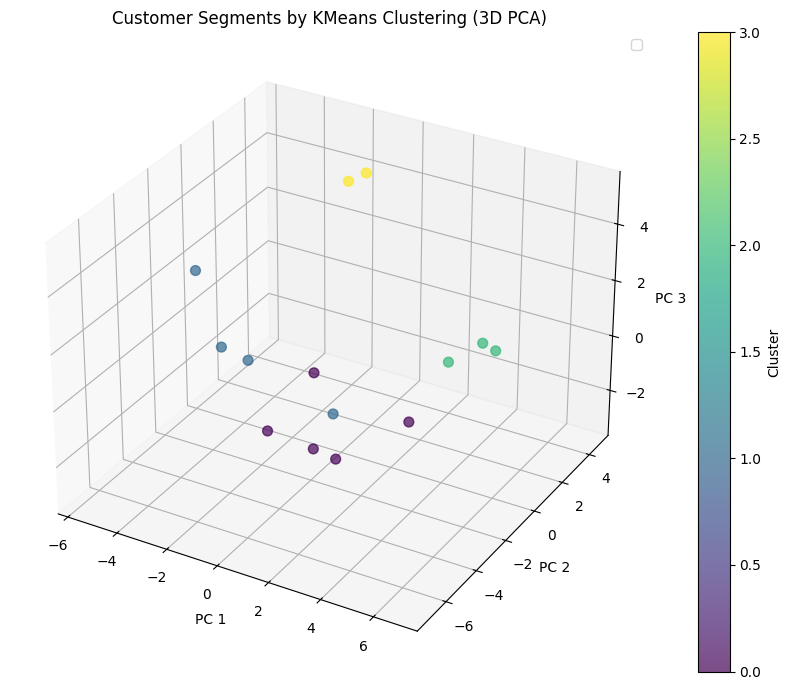

In [51]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)

ax.set_title("Customer Segments by KMeans Clustering (3D PCA)")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.legend()
fig.colorbar(sc, label="Cluster")
plt.tight_layout()
plt.show()

In [49]:
# Silhouette Score
score = silhouette_score(X_scaled, kmeans.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.2578856536723254


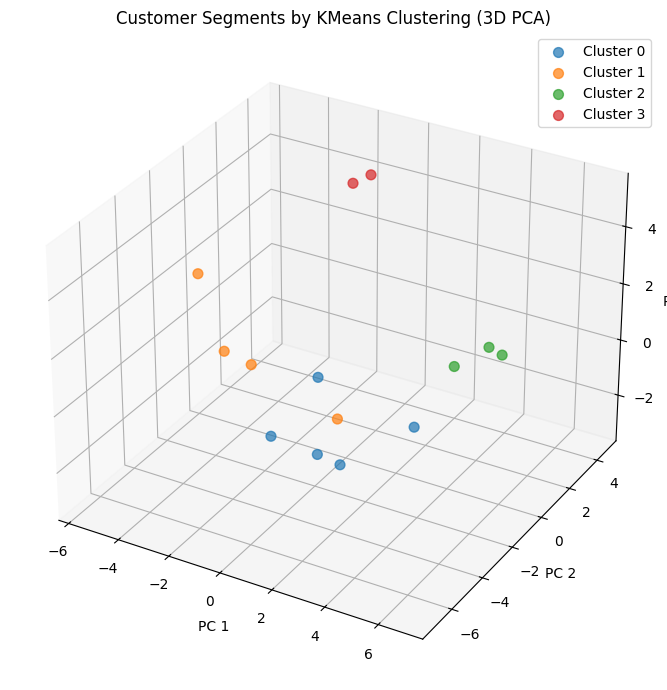

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with its label
for cluster_id in np.unique(kmeans.labels_):
    cluster_points = X_pca[kmeans.labels_ == cluster_id]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               label=f'Cluster {cluster_id}', s=50, alpha=0.7)

# Title and axes
ax.set_title("Customer Segments by KMeans Clustering (3D PCA)")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

# Add legend and color bar
ax.legend()
plt.tight_layout()
plt.show()
